In [4]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn.modules.loss import *
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
from pathlib import Path
%matplotlib notebook

In [5]:
from Loss.triplet import *
from session import *
from LR_Schedule.cyclical import Cyclical
from LR_Schedule.cos_anneal import CosAnneal
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
from validation import _AccuracyMeter
import Datasets.ImageData as ImageData
from Transforms.ImageTransforms import *
import util
import Datasets.ModelData as md

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
torch.cuda.set_device(0); torch.backends.cudnn.benchmark=True;

/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/torch/cuda/__init__.py:135: UserWarning: 
    Found GPU0 GeForce GTX 770 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [8]:
data_path = Path("/media/drake/MX500/Datasets/Kannada-MNIST")
train_path = data_path/'train.csv'
test_path = data_path/'test.csv'
df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [9]:
labels = df[df.columns[0]].to_numpy()
inputs = df[df.columns[1:]].to_numpy().reshape(-1, 28, 28)

ids = test_df[test_df.columns[0]].to_numpy()
test_inputs = test_df[test_df.columns[1:]].to_numpy().reshape(-1, 28, 28)

inputs.shape, labels.shape

((60000, 28, 28), (60000,))

In [10]:
class KannadaMNISTDataset(Dataset):
    def __init__(self, inputs, labels, transform):
        self.data = inputs
        self.targets = labels
        self.tsfm = transform
        
    def __len__(self): return self.targets.shape[0]
        
    def __getitem__(self, i):
        x, y = self.data[i], self.targets[i]  
        x = x.astype(np.uint8)
        x = self.tsfm(x)
        x = x.float()
        
        return x, y

In [11]:
i_dict = md.make_partition_indices(labels.shape[0], {'train': .95, 'valid': .05})

In [12]:
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.RandomRotation(9),
                                transforms.RandomResizedCrop(28, scale=(.95, 1.05)),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])

train_dataset = KannadaMNISTDataset(inputs[i_dict['train']], labels[i_dict['train']], transform)
valid_dataset = KannadaMNISTDataset(inputs[i_dict['valid']], labels[i_dict['valid']], transform)
test_dataset = KannadaMNISTDataset(test_inputs, ids, transform)
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valloader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [13]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

## Baseline

In [ ]:
model_base = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    Flatten(),
    nn.Linear(7 * 7 * 64, 1000),
    nn.Linear(1000, 10),
    # nn.LogSoftmax()
)

sess_base = Session(model_base, nn.CrossEntropyLoss(), optim.Adam, 1e-3)

In [ ]:
lr_find(sess_base, trainloader, start_lr=1e-7)

In [ ]:
sess_base.set_lr(1e-4)

In [ ]:
validator = Validator(valloader, OneHotAccuracy(), save_best=True, model_dir='./base')
lr_scheduler = CosAnneal(len(trainloader), T_mult=2)
schedule = TrainingSchedule(trainloader, [lr_scheduler, validator])
sess_base.train(schedule, 7)

In [ ]:
def inference_test_data(model, submission_path=None):
    if submission_path is None:
        submission_path = Path('./Kannada.submission.csv')
        
    submission = []
    
    model = util.to_gpu(model)
    
    with EvalModel(model):       
        for input, id in testloader:
            outputs = model(util.to_gpu(input))
            _, preds = torch.max(outputs, 1)
            

            batch = torch.stack([id, preds.cpu()], dim=1).numpy()          

            submission.append(batch)

    submission = np.concatenate(submission)
   
    df = pd.DataFrame(submission, columns=['id', 'label'])
    
    df.to_csv(submission_path, index=False)
        
    return df

In [ ]:
sub = inference_test_data(model_base)
sub

## Triplet Loss 


In [14]:
class TripletRegularizedCrossEntropyLoss(nn.Module):
    def __init__(self, alpha, margin):     
        super().__init__()
        self.alpha = alpha
        self.margin = margin
        
    def forward(self, x, y):
        loss = F.cross_entropy(x[-1], y)
        triplet = 0
        
        for layer in x[:-1]:
            triplet += batch_hard_triplet_loss(layer.view(layer.size(0), -1), y, self.margin)
            
        triplet *= min(self.alpha/math.sqrt(loss.item()), 1)
        triplet *= self.alpha
            
        return loss + triplet
    
    
class CustomOneHotAccuracy(OneHotAccuracy):
    def __init__(self):
        super().__init__()
        self.reset()

    def update(self, output, label):
        super().update(output[-1], label)
        
class SelectiveSequential(nn.Module):
    def __init__(self, to_select, modules_dict):
        super(SelectiveSequential, self).__init__()
        for key, module in modules_dict.items():
            self.add_module(key, module)
        self._to_select = to_select
    
    def forward(self, x):
        list = []
        for name, module in self._modules.items():
            x = module(x)
            if name in self._to_select:
                list.append(x)
        return list
    

In [15]:
model = SelectiveSequential(
    ['max1', 'max2', 'fc1', 'fc2', 'out'],
    {'conv16': nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
     'act16': nn.ReLU(),
    
     'conv32': nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
     'act32': nn.ReLU(),
    
     'max1': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv64': nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
     'act64': nn.ReLU(),
     
     'conv32b': nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
     'act32b': nn.ReLU(),
     
     'max2': nn.MaxPool2d(kernel_size=2, stride=2),

    'flatten': Flatten(),
    'fc1': nn.Linear(7 * 7 * 32, 512),
    'fc2': nn.Linear(512, 256),
    'out': nn.Linear(256, 10)}
)

In [16]:
criterion = TripletRegularizedCrossEntropyLoss(.25, 1)
sess = Session(model, criterion, optim.Adam, 1e-3)

<IPython.core.display.Javascript object>


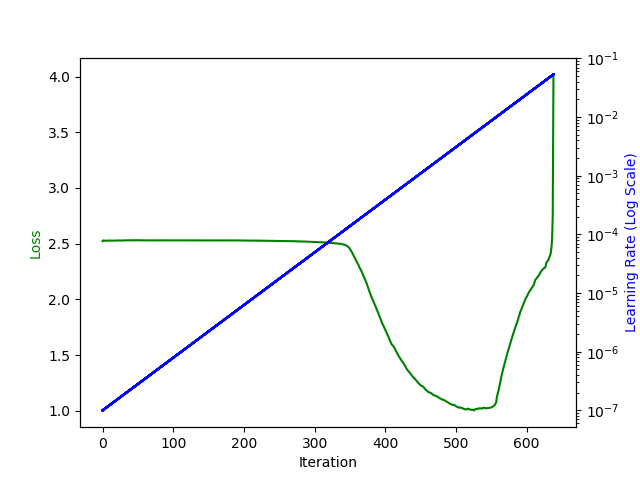

In [17]:
lr_find(sess, trainloader, start_lr=1e-7)

In [18]:
sess.set_lr(5e-4)

In [19]:
validator = Validator(valloader, CustomOneHotAccuracy(), save_best=True, model_dir='./triplet')
lr_scheduler = CosAnneal(len(trainloader), T_mult=2)
schedule = TrainingSchedule(trainloader, [lr_scheduler, validator])
sess.train(schedule, 31)

Validating: 100%|██████████| 47/47 [00:01<00:00, 38.76it/s]


Training Loss: 0.8189326524734497  Validaton Loss: 0.8057296276092529 Validation Accuracy: 0.9896666666666666


Validating: 100%|██████████| 47/47 [00:01<00:00, 40.14it/s]


Training Loss: 0.7214283347129822  Validaton Loss: 0.6963302493095398 Validation Accuracy: 0.9936666666666666


Validating: 100%|██████████| 47/47 [00:01<00:00, 40.16it/s]


Training Loss: 0.6720517873764038  Validaton Loss: 0.6618590950965881 Validation Accuracy: 0.9946666666666666


Validating: 100%|██████████| 47/47 [00:01<00:00, 40.41it/s]

Training Loss: 0.6602077484130859  Validaton Loss: 0.6650410890579224 Validation Accuracy: 0.99


Validating: 100%|██████████| 47/47 [00:01<00:00, 39.90it/s]


Training Loss: 0.6206750273704529  Validaton Loss: 0.6128929853439331 Validation Accuracy: 0.9953333333333333


Validating: 100%|██████████| 47/47 [00:01<00:00, 39.97it/s]


Training Loss: 0.5999667048454285  Validaton Loss: 0.5991351008415222 Validation Accuracy: 0.996


Validating: 100%|██████████| 47/47 [00:01<00:00, 39.46it/s]

Training Loss: 0.6158831715583801  Validaton Loss: 0.6018255352973938 Validation Accuracy: 0.996


Validating: 100%|██████████| 47/47 [00:01<00:00, 40.41it/s]


Training Loss: 0.6225256323814392  Validaton Loss: 0.6104891896247864 Validation Accuracy: 0.9936666666666666


Validating: 100%|██████████| 47/47 [00:01<00:00, 39.81it/s]


Training Loss: 0.5956984162330627  Validaton Loss: 0.5934549570083618 Validation Accuracy: 0.9963333333333333


Validating: 100%|██████████| 47/47 [00:01<00:00, 40.53it/s]

Training Loss: 0.5854418277740479  Validaton Loss: 0.5891430377960205 Validation Accuracy: 0.9966666666666666


Validating: 100%|██████████| 47/47 [00:01<00:00, 39.77it/s]

Training Loss: 0.5763269662857056  Validaton Loss: 0.575313925743103 Validation Accuracy: 0.9956666666666666


Validating: 100%|██████████| 47/47 [00:01<00:00, 39.97it/s]


Training Loss: 0.5756825804710388  Validaton Loss: 0.5685910582542419 Validation Accuracy: 0.9973333333333333


Validating: 100%|██████████| 47/47 [00:01<00:00, 39.96it/s]

Training Loss: 0.5703939199447632  Validaton Loss: 0.5627748370170593 Validation Accuracy: 0.9973333333333333


Validating: 100%|██████████| 47/47 [00:01<00:00, 40.06it/s]

Training Loss: 0.5638198852539062  Validaton Loss: 0.5544560551643372 Validation Accuracy: 0.997


Validating: 100%|██████████| 47/47 [00:01<00:00, 40.50it/s]


Training Loss: 0.5534539222717285  Validaton Loss: 0.5642850399017334 Validation Accuracy: 0.9966666666666666


Validating: 100%|██████████| 47/47 [00:01<00:00, 39.20it/s]

Training Loss: 0.5832133889198303  Validaton Loss: 0.5790337920188904 Validation Accuracy: 0.996


Validating: 100%|██████████| 47/47 [00:01<00:00, 39.86it/s]


Training Loss: 0.5883492827415466  Validaton Loss: 0.5694617033004761 Validation Accuracy: 0.9946666666666666


Validating: 100%|██████████| 47/47 [00:01<00:00, 39.95it/s]

Training Loss: 0.5604308843612671  Validaton Loss: 0.5653041005134583 Validation Accuracy: 0.996


Validating: 100%|██████████| 47/47 [00:01<00:00, 39.65it/s]

Training Loss: 0.5760645270347595  Validaton Loss: 0.5684772729873657 Validation Accuracy: 0.995


Validating: 100%|██████████| 47/47 [00:01<00:00, 38.71it/s]

Training Loss: 0.5636578798294067  Validaton Loss: 0.5576738119125366 Validation Accuracy: 0.996


Validating: 100%|██████████| 47/47 [00:01<00:00, 37.88it/s]

Training Loss: 0.553753674030304  Validaton Loss: 0.5570612549781799 Validation Accuracy: 0.995


Validating: 100%|██████████| 47/47 [00:01<00:00, 39.62it/s]

Training Loss: 0.5367347002029419  Validaton Loss: 0.5464513301849365 Validation Accuracy: 0.9963333333333333


Validating: 100%|██████████| 47/47 [00:01<00:00, 36.28it/s]

Training Loss: 0.5336765646934509  Validaton Loss: 0.5405786037445068 Validation Accuracy: 0.9966666666666666


Validating: 100%|██████████| 47/47 [00:01<00:00, 38.65it/s]

Training Loss: 0.5267555713653564  Validaton Loss: 0.5313124060630798 Validation Accuracy: 0.997


Validating: 100%|██████████| 47/47 [00:01<00:00, 39.80it/s]

Training Loss: 0.5197668075561523  Validaton Loss: 0.5248785614967346 Validation Accuracy: 0.997


Validating: 100%|██████████| 47/47 [00:01<00:00, 38.97it/s]

Training Loss: 0.516030490398407  Validaton Loss: 0.5151762366294861 Validation Accuracy: 0.9963333333333333


Validating: 100%|██████████| 47/47 [00:01<00:00, 38.38it/s]

Training Loss: 0.5162439346313477  Validaton Loss: 0.5204252600669861 Validation Accuracy: 0.9956666666666666


Validating: 100%|██████████| 47/47 [00:01<00:00, 40.17it/s]

Training Loss: 0.5194947123527527  Validaton Loss: 0.5120308995246887 Validation Accuracy: 0.9966666666666666


Validating: 100%|██████████| 47/47 [00:01<00:00, 38.92it/s]

Training Loss: 0.495785653591156  Validaton Loss: 0.509146511554718 Validation Accuracy: 0.9966666666666666


Validating: 100%|██████████| 47/47 [00:01<00:00, 39.70it/s]

Training Loss: 0.5067558288574219  Validaton Loss: 0.5069277882575989 Validation Accuracy: 0.9973333333333333


Validating: 100%|██████████| 47/47 [00:01<00:00, 40.00it/s]

Training Loss: 0.5063837170600891  Validaton Loss: 0.5122607946395874 Validation Accuracy: 0.9973333333333333



In [ ]:
sess2 = Session(model, TripletRegularizedCrossEntropyLoss(0, 1), optim.Adam, 1e-4)
validator = Validator(valloader, CustomOneHotAccuracy(), save_best=True, model_dir='./triplet')
lr_scheduler = CosAnneal(len(trainloader), T_mult=2)
schedule = TrainingSchedule(trainloader, [lr_scheduler, validator])
sess2.train(schedule, 7)